In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np

path_to_kaggle_pos = "/content/drive/MyDrive/DATASET/MRI/yes"
path_to_kaggle_neg = "/content/drive/MyDrive/DATASET/MRI/no"


In [3]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, true)

NameError: name 'true' is not defined

In [4]:
import os
import cv2
import numpy as np

# Parameters
img_height = 64
x_data = []
y_data = []

# Load tumor images (positive samples)
for img_name in os.listdir(path_to_kaggle_pos):
    img_path = os.path.join(path_to_kaggle_pos, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image: {img_path}")
        continue
    img = cv2.resize(img, (img_height, img_height))
    x_data.append(img)
    y_data.append(1)  # Label for tumor present

# Load healthy images (negative samples)
for img_name in os.listdir(path_to_kaggle_neg):
    img_path = os.path.join(path_to_kaggle_neg, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image: {img_path}")
        continue
    img = cv2.resize(img, (img_height, img_height))
    x_data.append(img)
    y_data.append(0)  # Label for no tumor

# Convert to numpy arrays
x_data = np.array(x_data)
y_data = np.array(y_data)

# Normalize images
x_data = (x_data.astype(np.float32) - 127.5) / 127.5
x_data = x_data.reshape(-1, img_height, img_height, 1)  # Add channel dimension

print(f"Dataset shape: {x_data.shape}, Labels shape: {y_data.shape}")


Dataset shape: (3000, 64, 64, 1), Labels shape: (3000,)


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split


In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
print(f"Training data shape: {x_train.shape}, Testing data shape: {x_test.shape}")


Training data shape: (2400, 64, 64, 1), Testing data shape: (600, 64, 64, 1)


In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 682,753 (2.60 MB)

 Trainable params: 682,753 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=20, batch_size=32)


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6488 - loss: 0.6108 - val_accuracy: 0.7604 - val_loss: 0.4707
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7996 - loss: 0.4459 - val_accuracy: 0.8188 - val_loss: 0.3885
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8530 - loss: 0.3443 - val_accuracy: 0.8771 - val_loss: 0.2593
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9144 - loss: 0.2212 - val_accuracy: 0.9312 - val_loss: 0.1625
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9491 - loss: 0.1547 - val_accuracy: 0.9521 - val_loss: 0.1239
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9747 - loss: 0.0743 - val_accuracy: 0.9625 - val_loss: 0.1168
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9726 - loss: 0.0780 - val_accuracy: 0.9688 - val_loss: 0.0831
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9862 - loss: 0.0461 - val_accuracy: 0.9729 - val_l

In [9]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9822 - loss: 0.1089
Test Accuracy: 98.17%


In [10]:
model.save("cnn_model.h5")

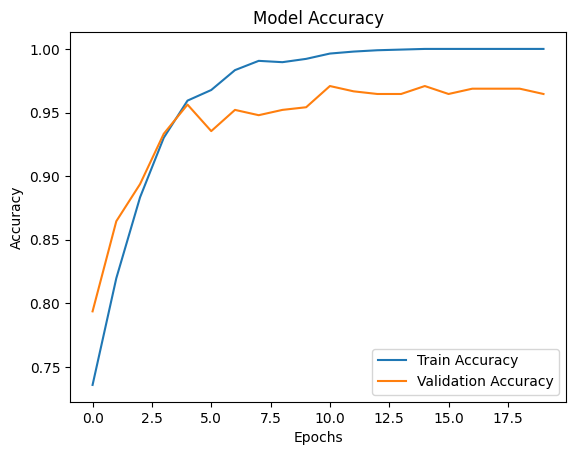

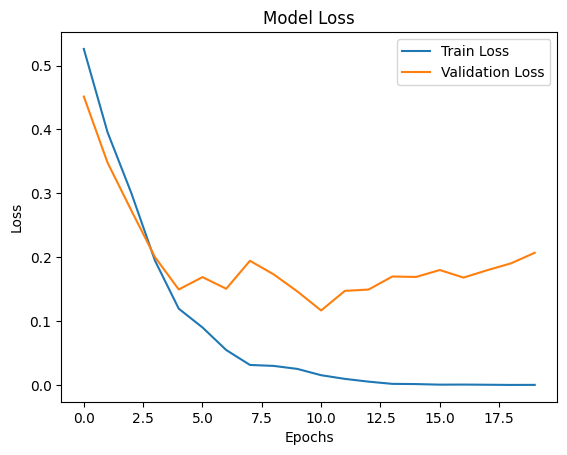

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model.save("brain_tumor_detection_model.h5")
print("Model saved successfully.")


Model saved successfully.


In [ ]:
import numpy as np

# Example: Predict the first test image
prediction = model.predict(np.expand_dims(x_test[0], axis=0))
print(f"Predicted label: {round(prediction[0][0])}")  # 0 (no tumor) or 1 (tumor)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted label: 0


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
# Get predictions (probabilities)
y_pred_prob = model.predict(x_test)

# Convert probabilities to binary labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)  # Threshold at 0.5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Tumor", "Tumor"]))


Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.96      0.98      0.97       287
       Tumor       0.98      0.96      0.97       313

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



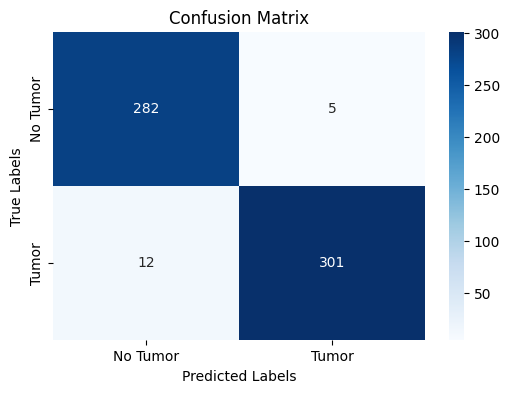

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.save("brain_tumor_classification_model.h5")


In [ ]:
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


Implement ResNet50


In [ ]:
history_resnet = resnet_model.fit(x_train, y_train, validation_split=0.2, epochs=20, batch_size=32)


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.5585 - loss: 0.9723 - val_accuracy: 0.5188 - val_loss: 0.7025
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.7095 - loss: 0.6056 - val_accuracy: 0.5188 - val_loss: 0.8632
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8344 - loss: 0.3917 - val_accuracy: 0.5188 - val_loss: 0.8946
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9062 - loss: 0.2556 - val_accuracy: 0.5188 - val_loss: 1.5234
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.9102 - loss: 0.2383 - val_accuracy: 0.5229 - val_loss: 1.2873
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.9309 - loss: 0.1915 - val_accuracy: 0.6083 - val_loss: 0.9071
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.9490 - loss: 0.1299 - val_accuracy: 0.6583 - val_loss: 0.8452
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.9499 - loss: 0.1432 - val_accuracy: 0.7354 - v

In [ ]:
resnet_loss, resnet_accuracy = resnet_model.evaluate(x_test, y_test)
print(f"ResNet50 Test Accuracy: {resnet_accuracy * 100:.2f}%")


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.8923 - loss: 0.4636
ResNet50 Test Accuracy: 91.00%


In [ ]:
resnet_model.save("ResNet50_model1.h5")

In [ ]:
def build_efficientnet_model(input_shape=(64, 64, 1)):
    base_model = EfficientNetB0(weights=None, include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)  # Binary classification
    model = Model(inputs=base_model.input, outputs=x)

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build EfficientNet model
efficientnet_model = build_efficientnet_model(input_shape=(64, 64, 1))
efficientnet_model.summary()


Model: "functional_2"

 Non-trainable params: 42,019 (164.14 KB)

In [ ]:
history_efficientnet = efficientnet_model.fit(x_train, y_train, validation_split=0.2, epochs=20, batch_size=32)


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 69s 475ms/step - accuracy: 0.5319 - loss: 0.7320 - val_accuracy: 0.5188 - val_loss: 0.6928
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 458ms/step - accuracy: 0.5922 - loss: 0.6775 - val_accuracy: 0.5188 - val_loss: 0.6928
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 447ms/step - accuracy: 0.6853 - loss: 0.5956 - val_accuracy: 0.5188 - val_loss: 0.6944
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 448ms/step - accuracy: 0.7517 - loss: 0.5251 - val_accuracy: 0.5188 - val_loss: 0.7173
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 434ms/step - accuracy: 0.7752 - loss: 0.4690 - val_accuracy: 0.4812 - val_loss: 0.6963
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 443ms/step - accuracy: 0.8175 - loss: 0.3877 - val_accuracy: 0.5375 - val_loss: 0.6870
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 438ms/step - accuracy: 0.8544 - loss: 0.3452 - val_accuracy: 0.5188 - val_loss: 0.7126
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 438ms/step - accuracy: 0.8932 - loss: 0.2650 - val_accu

In [ ]:
efficientnet_loss, efficientnet_accuracy = efficientnet_model.evaluate(x_test, y_test)
print(f"EfficientNetB0 Test Accuracy: {efficientnet_accuracy * 100:.2f}%")


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.8658 - loss: 0.3841
EfficientNetB0 Test Accuracy: 88.17%


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    GlobalAveragePooling2D, Add, Multiply, Reshape
)
from tensorflow.keras.optimizers import Adam

# Squeeze-and-Excitation Block for Attention
def se_block(input_tensor, reduction=8):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(max(filters // reduction, 4), activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape([1, 1, filters])(se)
    return Multiply()([input_tensor, se])

# Hybrid Model

def build_hybrid_model(input_shape=(64, 64, 1)):
    inputs = Input(shape=input_shape)

    # Block 1: AlexNet-inspired layers
    x = Conv2D(64, (5, 5), strides=(1, 1), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Conv2D(128, (5, 5), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Block 2: Residual and Attention block
    shortcut = x
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, shortcut])  # Residual connection
    x = se_block(x, reduction=8)  # Attention mechanism

    # Block 3: CNN-inspired layers
    x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Global Average Pooling and Fully Connected Layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and summarize the hybrid model
hybrid_model = build_hybrid_model(input_shape=(64, 64, 1))
hybrid_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 64, 64, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 64, 64, 64)     │          1,664 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 64, 64, 64)     │            256 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 32, 32, 128)    │        204,928 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 32, 32, 128)    │            512 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 16, 16, 128)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 16, 16, 128)    │        147,584 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 16, 16, 128)    │            512 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 16, 16, 128)    │        147,584 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 16, 16, 128)    │            512 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 16, 16, 128)    │              0 │ batch_normalization_1… │
│                           │                        │                │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ add_3[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 16)             │          2,064 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 128)            │          2,176 │ dense_8[0][0]          │
├──────────────────────

 Total params: 1,148,113 (4.38 MB)

 Trainable params: 1,147,217 (4.38 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
history_alexnet = alexnet_model.fit(x_train, y_train, validation_split=0.2, epochs=20, batch_size=32)


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 57s 906ms/step - accuracy: 0.5939 - loss: 1.1011 - val_accuracy: 0.4833 - val_loss: 0.7186
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 904ms/step - accuracy: 0.7437 - loss: 0.5110 - val_accuracy: 0.5188 - val_loss: 0.7110
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 55s 916ms/step - accuracy: 0.8041 - loss: 0.4337 - val_accuracy: 0.5542 - val_loss: 0.6862
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 54s 897ms/step - accuracy: 0.8466 - loss: 0.3768 - val_accuracy: 0.6333 - val_loss: 0.7689
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 56s 937ms/step - accuracy: 0.8989 - loss: 0.2654 - val_accuracy: 0.7542 - val_loss: 0.4879
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 55s 914ms/step - accuracy: 0.9296 - loss: 0.1897 - val_accuracy: 0.7312 - val_loss: 0.7798
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 54s 900ms/step - accuracy: 0.9697 - loss: 0.1006 - val_accuracy: 0.8042 - val_loss: 0.5008
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 908ms/step - accuracy: 0.9463 - loss: 0.1508 - val_accu

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict probabilities on the test set
alexnet_preds_prob = alexnet_model.predict(x_test)

# Convert probabilities to binary predictions
alexnet_preds = (alexnet_preds_prob > 0.5).astype(int)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step


AlexNet Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.95      0.98      0.96       287
       Tumor       0.98      0.95      0.97       313

    accuracy                           0.96       600
   macro avg       0.96      0.97      0.96       600
weighted avg       0.97      0.96      0.97       600



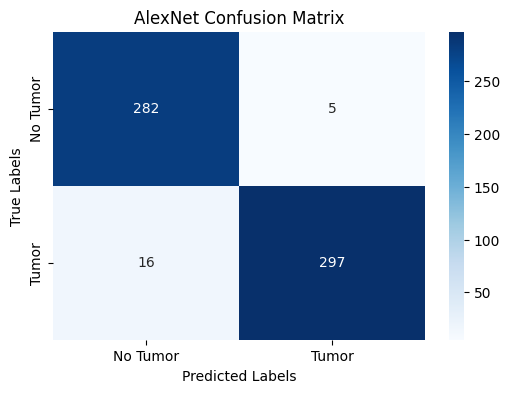

In [ ]:
# Generate classification report
print("AlexNet Classification Report:")
print(classification_report(y_test, alexnet_preds, target_names=["No Tumor", "Tumor"]))

# Generate confusion matrix
conf_matrix_alexnet = confusion_matrix(y_test, alexnet_preds)

# Display confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_alexnet, annot=True, fmt='d', cmap='Blues', xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('AlexNet Confusion Matrix')
plt.show()


In [ ]:
import os
import cv2
import numpy as np

# Path to the directory containing .jpg images
pred_directory = "/kaggle/input/brain-tumor-detection/pred"  # Replace with the actual directory

# Parameters
img_height = 64
img_width = 64

# Load all .jpg images and preprocess them
pred_features = []
for img_name in os.listdir(pred_directory):
    if img_name.endswith('.jpg'):
        img_path = os.path.join(pred_directory, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
        img = cv2.resize(img, (img_width, img_height))  # Resize to (64, 64)
        pred_features.append(img)

# Convert to a NumPy array
pred_features = np.array(pred_features).astype('float32') / 255.0  # Normalize
pred_features = pred_features.reshape(-1, img_height, img_width, 1)  # Add channel dimension

print(f"Loaded features shape: {pred_features.shape}")


Loaded features shape: (60, 64, 64, 1)


In [ ]:
# Flatten features
pred_features_flat = pred_features.reshape(pred_features.shape[0], -1)  # Flatten each image
print(f"Flattened feature shape: {pred_features_flat.shape}")


Flattened feature shape: (60, 4096)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build a simple classifier
def build_simple_classifier(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train the classifier
simple_classifier = build_simple_classifier(pred_features_flat.shape[1])
history = simple_classifier.fit(pred_features_flat, y_train, validation_split=0.2, epochs=20, batch_size=8)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4875 - loss: 1.1873 - val_accuracy: 0.3333 - val_loss: 1.0356
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3714 - loss: 1.1372 - val_accuracy: 0.7500 - val_loss: 0.6720
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6298 - loss: 0.6579 - val_accuracy: 0.4167 - val_loss: 1.1263
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6232 - loss: 0.7442 - val_accuracy: 0.5000 - val_loss: 0.7509
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6658 - loss: 0.7378 - val_accuracy: 0.7500 - val_loss: 0.7177
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6929 - loss: 0.5612 - val_accuracy: 0.3333 - val_loss: 1.0889
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7878 - loss: 0.5534 - val_accuracy: 0.5000 - val_loss: 0.7217
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8455 - loss: 0.4570 - val_accuracy: 0.6667 - val_loss: 0.6993
Epoch 9/20


In [ ]:
import numpy as np

# Build the CNN and AlexNet models by passing dummy data
dummy_input = np.random.rand(1, 64, 64, 1)  # Dummy input with shape (batch_size, height, width, channels)
_ = model.predict(dummy_input)  # Build CNN
_ = alexnet_model.predict(dummy_input)  # Build AlexNet


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define CNN with input shape
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)                   │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 682,753 (2.60 MB)

 Trainable params: 682,753 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define AlexNet with input shape
def build_alexnet(input_shape=(64, 64, 1)):
    model = Sequential([
        Conv2D(64, (5, 5), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (5, 5), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(192, (3, 3), activation='relu'),
        Conv2D(192, (3, 3), activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

alexnet_model = build_alexnet(input_shape=(64, 64, 1))
alexnet_model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)                   │ (None, 60, 60, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 60, 60, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 26, 26, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 26, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 11, 11, 192)         │         221,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 9, 9, 192)           │         331,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 7, 7, 128)           │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 512)                 │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,703,937 (6.50 MB)

 Trainable params: 1,703,553 (6.50 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# Initialize models by calling them with training data
_ = model.predict(x_train[:1])  # Use a single sample from training data to initialize CNN
_ = alexnet_model.predict(x_train[:1])  # Use a single sample to initialize AlexNet


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
def build_alexnet(input_shape=(64, 64, 1)):
    model = Sequential([
        Conv2D(64, (5, 5), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (5, 5), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(192, (3, 3), activation='relu'),
        Conv2D(192, (3, 3), activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

alexnet_model = build_alexnet()


In [ ]:
# Train CNN
model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=32)

# Train AlexNet
alexnet_model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=32)


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.6800 - loss: 0.5911 - val_accuracy: 0.8021 - val_loss: 0.4598
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.8066 - loss: 0.4097 - val_accuracy: 0.8146 - val_loss: 0.4020
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.8697 - loss: 0.3290 - val_accuracy: 0.8958 - val_loss: 0.3208
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.9131 - loss: 0.2322 - val_accuracy: 0.9146 - val_loss: 0.2251
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9348 - loss: 0.1766 - val_accuracy: 0.9375 - val_loss: 0.1955
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.9720 - loss: 0.1025 - val_accuracy: 0.9354 - val_loss: 0.1705
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.9802 - loss: 0.0572 - val_accuracy: 0.9458 - val_loss: 0.1738
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.9860 - loss: 0.0470 - val_accuracy: 

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Parameters
img_height = 64
x_data = []
y_data = []

# Paths
path_to_kaggle_pos = "/kaggle/input/brain-tumor-detection/yes"
path_to_kaggle_neg = "/kaggle/input/brain-tumor-detection/no"

# Load tumor images (positive samples)
for img_name in os.listdir(path_to_kaggle_pos):
    img_path = os.path.join(path_to_kaggle_pos, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image: {img_path}")
        continue
    img = cv2.resize(img, (img_height, img_height))
    x_data.append(img)
    y_data.append(1)  # Label for tumor present

# Load healthy images (negative samples)
for img_name in os.listdir(path_to_kaggle_neg):
    img_path = os.path.join(path_to_kaggle_neg, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image: {img_path}")
        continue
    img = cv2.resize(img, (img_height, img_height))
    x_data.append(img)
    y_data.append(0)  # Label for no tumor

# Convert to numpy arrays
x_data = np.array(x_data)
y_data = np.array(y_data)

# Normalize images
x_data = (x_data.astype(np.float32) - 127.5) / 127.5
x_data = x_data.reshape(-1, img_height * img_height)  # Flatten images for ML models

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier()
}

# Train and evaluate models
results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {name}: {acc:.2f}")
    print(classification_report(y_test, y_pred))
    results.append((name, acc))

# Display results
results_df = pd.DataFrame(results, columns=["Model", "Accuracy"])
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)
print("\nModel Performance:")
print(results_df)


Training Logistic Regression...
Accuracy for Logistic Regression: 0.97
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       287
           1       0.97      0.97      0.97       313

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600

Training SVM...
Accuracy for SVM: 0.97
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       287
           1       0.97      0.97      0.97       313

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600

Training Random Forest...
Accuracy for Random Forest: 0.96
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       287
           1       0.96      0.96      0.96       313

    accuracy 